‖dS1(QM)-dS1(SC2)‖ = 1.570e-16
‖dS2(QM)-dS2(SC2)‖ = 1.144e-16
‖dT (QM)-dT (SC2)‖ = 3.189e-16


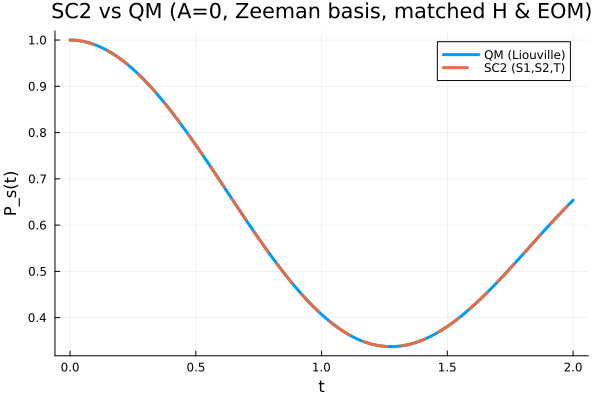

[ Info: max |Ps_SC2 - Ps_QM| = 1.4710455076283324e-13


In [1]:
using LinearAlgebra
using StaticArrays
using DifferentialEquations
using Random
using Printf
using Plots

# ---------------- Pauli & tensor helpers (Zeeman basis) ----------------
const σx = ComplexF64[0 1; 1 0]
const σy = ComplexF64[0 -im; im 0]
const σz = ComplexF64[1 0; 0 -1]
const I2 = Matrix{ComplexF64}(I,2,2)

σ(i) = i==1 ? σx : i==2 ? σy : σz
σ1(i) = kron(σ(i), I2)
σ2(j) = kron(I2, σ(j))
σ1σ2(i,j) = kron(σ(i), σ(j))

# Singlet projector (Zeeman basis: |↑↑>,|↑↓>,|↓↑>,|↓↓>)
const Ps = 0.5*ComplexF64[0 0 0 0;
                          0 1 -1 0;
                          0 -1 1 0;
                          0 0 0 0]

# Expectation maps from ρ (Pauli units)
function ST_from_rho(ρ::AbstractMatrix{<:Complex})
    S1 = @SVector [real(tr(ρ*σ1(i))) for i in 1:3]
    S2 = @SVector [real(tr(ρ*σ2(j))) for j in 1:3]
    T  = @SMatrix [real(tr(ρ*σ1σ2(i,j))) for i in 1:3, j in 1:3]
    return S1, S2, T
end

# Cross matrix and axial (vee) map
crossmat(v::SVector{3,Float64}) = @SMatrix [ 0.0 -v[3]  v[2];
                                             v[3]  0.0 -v[1];
                                            -v[2]  v[1]  0.0 ]
axial(M::SMatrix{3,3,Float64}) = @SVector [ M[2,3]-M[3,2],
                                            M[3,1]-M[1,3],
                                            M[1,2]-M[2,1] ]
# ---------------- Our Hamiltonian (Zeeman basis, Pauli units) ----------------
# H = 1/2 ω1·(σ⊗I) + 1/2 ω2·(I⊗σ) + 1/4 Σ_ij C_ij (σ_i⊗σ_j)
function H_two_electrons(ω1::SVector{3,Float64},
                         ω2::SVector{3,Float64},
                         C::SMatrix{3,3,Float64})
    H = zeros(ComplexF64, 4,4)
    for i in 1:3
        H .+= 0.5*ω1[i]*σ1(i) + 0.5*ω2[i]*σ2(i)
    end
    for i in 1:3, j in 1:3
        H .+= 0.25*C[i,j]*σ1σ2(i,j)
    end
    return H
end

# ---------------- Exact Liouville propagation ----------------
# dρ/dt = -i [H, ρ] ; integrate ρ as a 16-vector
function rhodot!(dρvec, ρvec, p, t)
    H = p.H
    ρ = reshape(ρvec, 4,4)
    dρ = -1im*(H*ρ - ρ*H)
    dρvec .= vec(dρ)
    return nothing
end

# ---------------- SC2 ODE (A=0), matched to the Hamiltonian above ----------------
# u = [S1(3); S2(3); vec(T)(9)] with T packed column-major: xx,yx,zx, xy,yy,zy, xz,yz,zz
# EOM (derived from the same H):
#   dS1 = ω1×S1 + (1/2) axial(C*T')
#   dS2 = ω2×S2 + (1/2) axial(C' * T)
#   dT  = [ω1]× T  -  T [ω2]×  - (1/2)[S1]× C  - (1/2) C [S2]×^T
function SC2!(du,u,p,t)
    S1 = SVector{3,Float64}(u[1:3])
    S2 = SVector{3,Float64}(u[4:6])
    # unpack T (column-major)
    T  = @SMatrix [u[ 7] u[10] u[13];
                   u[ 8] u[11] u[14];
                   u[ 9] u[12] u[15]]

    ω1, ω2, C = p.ω1, p.ω2, p.C

    dS1 = cross(ω1, S1) + 0.5*axial(C*T')
    dS2 = cross(ω2, S2) + 0.5*axial(C' * T)
    dT  =  crossmat(ω1)*T -
           T*crossmat(ω2) -
           0.5*crossmat(S1)*C -
           0.5*C*transpose(crossmat(S2))

    du[1:3]  .= dS1
    du[4:6]  .= dS2
    du[7:15] .= vec(dT)
    return nothing
end

# ---------------- Demo / comparison ----------------
# Parameters (feel free to edit)
ω1 = @SVector [0.0, 0.0, 2.0]
ω2 = @SVector [0.4, 0.0, 0.0]
C  = @SMatrix [ 3.0  0.0  0.0;
                0.0  0.0  0.0;
                0.0  0.0  0.0 ]  # any real 3×3 coupling

# Initial quantum state ρ0 (example: |↑↓⟩⟨↑↓|)
ρ0 = zeros(ComplexF64,4,4)#; ρ0[2,2]=1
ρ0 += Ps
S1_0, S2_0, T_0 = ST_from_rho(ρ0)   # map QM → SC2 (no scaling ambiguity)
u0 = zeros(15); u0[1:3].=S1_0; u0[4:6].=S2_0; u0[7:15].=vec(T_0)

# Exact Liouville solve
H = H_two_electrons(ω1, ω2, C)
prob_qm  = ODEProblem(rhodot!, vec(ρ0), (0.0, 2.0), (;H))
sol_qm   = solve(prob_qm, Tsit5(); saveat=0:0.01:2, reltol=1e-12, abstol=1e-12)

# SC2 solve
prob_sc2 = ODEProblem(SC2!, u0, (0.0, 2.0), (;ω1, ω2, C))
sol_sc2  = solve(prob_sc2, Tsit5(); saveat=0:0.01:2, reltol=1e-12, abstol=1e-12)

# Extract Ps(t) from both
Ps_qm  = [real(tr(Ps*reshape(sol_qm.u[k],4,4))) for k in eachindex(sol_qm.t)]
Ps_sc2 = [0.25 - 0.25*tr(Matrix(@SMatrix [sol_sc2.u[k][ 7] sol_sc2.u[k][10] sol_sc2.u[k][13];
                                          sol_sc2.u[k][ 8] sol_sc2.u[k][11] sol_sc2.u[k][14];
                                          sol_sc2.u[k][ 9] sol_sc2.u[k][12] sol_sc2.u[k][15]]) )
          for k in eachindex(sol_sc2.t)]

# Derivative self-check at t=0 (optional but reassuring)
let
    # random pure state check
    rng = MersenneTwister(0)
    ψ = randn(rng, ComplexF64, 4); ψ ./= norm(ψ)
    ρ = ψ*ψ'
    S1,S2,T = ST_from_rho(ρ)

    ρdot = -1im*(H*ρ - ρ*H)
    dS1_qm = @SVector [real(tr(ρdot*σ1(i))) for i in 1:3]
    dS2_qm = @SVector [real(tr(ρdot*σ2(j))) for j in 1:3]
    dT_qm  = @SMatrix [real(tr(ρdot*σ1σ2(i,j))) for i in 1:3, j in 1:3]

    dS1_sc2 = cross(ω1,S1) + 0.5*axial(C*T')
    dS2_sc2 = cross(ω2,S2) + 0.5*axial(C'*T)
    dT_sc2  = crossmat(ω1)*T - T*crossmat(ω2) - 0.5*crossmat(S1)*C - 0.5*C*transpose(crossmat(S2))

    @printf "‖dS1(QM)-dS1(SC2)‖ = %.3e\n" norm(dS1_qm - dS1_sc2)
    @printf "‖dS2(QM)-dS2(SC2)‖ = %.3e\n" norm(dS2_qm - dS2_sc2)
    @printf "‖dT (QM)-dT (SC2)‖ = %.3e\n" norm(Matrix(dT_qm - dT_sc2))
end

# Plot + report max error
plot(sol_qm.t,  Ps_qm;  lw=3, label="QM (Liouville)")
plot!(sol_sc2.t, Ps_sc2; lw=3, ls=:dash, label="SC2 (S1,S2,T)")
xlabel!("t"); ylabel!("P_s(t)")
title!("SC2 vs QM (A=0, Zeeman basis, matched H & EOM)")
display(current())

maxerr = maximum(abs.(Ps_qm .- Ps_sc2))
@info "max |Ps_SC2 - Ps_QM| = $maxerr"
